In [1]:
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import networkx as nx  # For graph algorithms
import ast  # To safely parse edge list strings into Python lists
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plots
from sklearn.model_selection import GroupKFold, GridSearchCV  # Grouped cross-validation and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [82]:
# read training data
df = pd.read_csv('train.csv')

## Inspect the Data

We inspect the train dataset to check the structure of the data and understand the dataset more. We check the summary statistics and look out for possible errors, missing values, outliers or duplicates. We also check the the datatypes of each variable and ensure they are of the proper type. 

In [4]:
df.head()

,language,sentence,n,edgelist,root
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11


In [5]:
# get number of rows and columns
df.shape

(10500, 5)

Target variable: root. 
It says the node that is the root. But to make the task simpler, we will turn it to a binary classification task. Such that, each row takes a node and the target variable will the is_root, where 0 will indicate that the node isn't the root and 1 indicates that it is the root.

This will cause data imbalance in the dataset because most of the classes will be 0. 

In [7]:
# check other variables in the data
df.columns

Index(['language', 'sentence', 'n', 'edgelist', 'root'], dtype='object')

In [8]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  10500 non-null  object
 1   sentence  10500 non-null  int64 
 2   n         10500 non-null  int64 
 3   edgelist  10500 non-null  object
 4   root      10500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 410.3+ KB


In [9]:
# Check for missing values
df.isnull().sum()

language    0
sentence    0
n           0
edgelist    0
root        0
dtype: int64

In [10]:
# Check for duplicates
df.duplicated().sum()

0

Training data contains no missing values or duplicated columns, which is good


In [12]:
# check the data types
df.dtypes

language    object
sentence     int64
n            int64
edgelist    object
root         int64
dtype: object

In [13]:
# Confirm the type of object
type(df['edgelist'].iloc[0])

str

Edgelist is of the datatype object (string).

It needs to be converted to a python edgelist which can be used to create the networkx tree

In [15]:
df.describe()

,sentence,n,root
count,10500.000000,10500.000000,10500.000000
mean,494.778000,18.807524,9.844476
std,290.256632,8.190593,7.207740
min,2.000000,3.000000,1.000000
25%,233.500000,13.000000,4.000000
50%,483.000000,18.000000,8.000000
75%,742.250000,23.000000,14.000000
max,995.000000,70.000000,68.000000


There are sentences with 3 nodes (words) and some with as many as 70 nodes. This should be taken into consideration when normalizing. it will be advisable to normalize per sentence coz of this imbalance

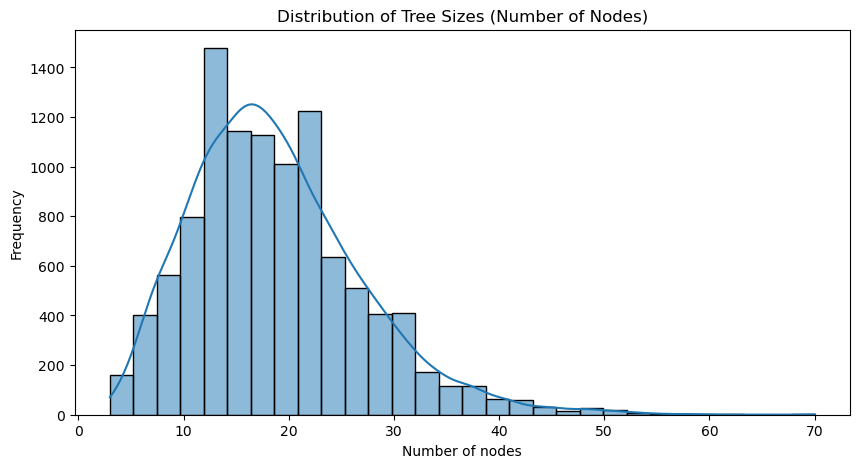

In [17]:
# Sentence length distribution
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='n', bins=30, kde=True)
plt.title('Distribution of Tree Sizes (Number of Nodes)')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Language distribution (check number of languages and number of sentences per language)
lang = df['language'].nunique()
print(f'There are {lang} languages. Each language has the following number of sentences:')
df['language'].value_counts()

There are 21 languages. Each language has the following number of sentences:


language
Japanese      500
German        500
Arabic        500
Portuguese    500
Chinese       500
Czech         500
Turkish       500
Thai          500
Polish        500
Korean        500
Icelandic     500
Finnish       500
Spanish       500
Swedish       500
Indonesian    500
Italian       500
French        500
Hindi         500
English       500
Galician      500
Russian       500
Name: count, dtype: int64

count    10500.000000
mean         9.844476
std          7.207740
min          1.000000
25%          4.000000
50%          8.000000
75%         14.000000
max         68.000000
Name: root, dtype: float64


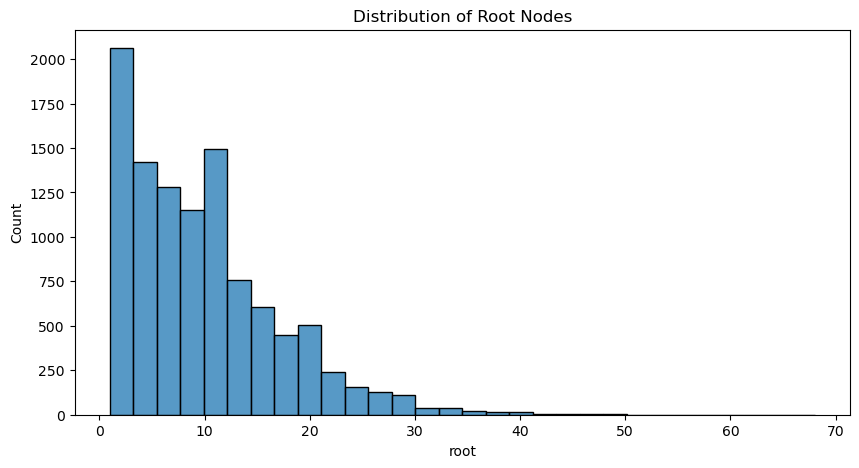

In [19]:
# Root node analysis
print(df['root'].describe())
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='root', bins=30)
plt.title('Distribution of Root Nodes')
plt.show()

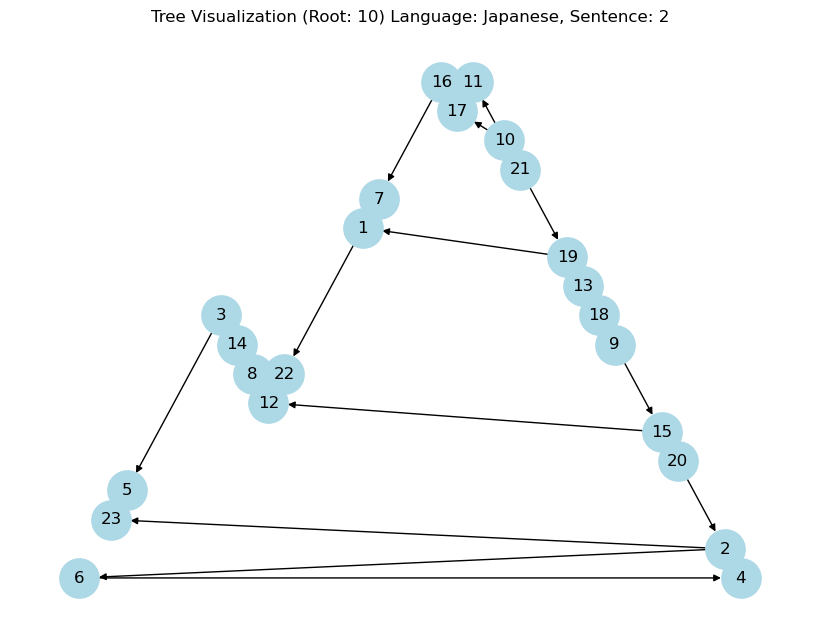

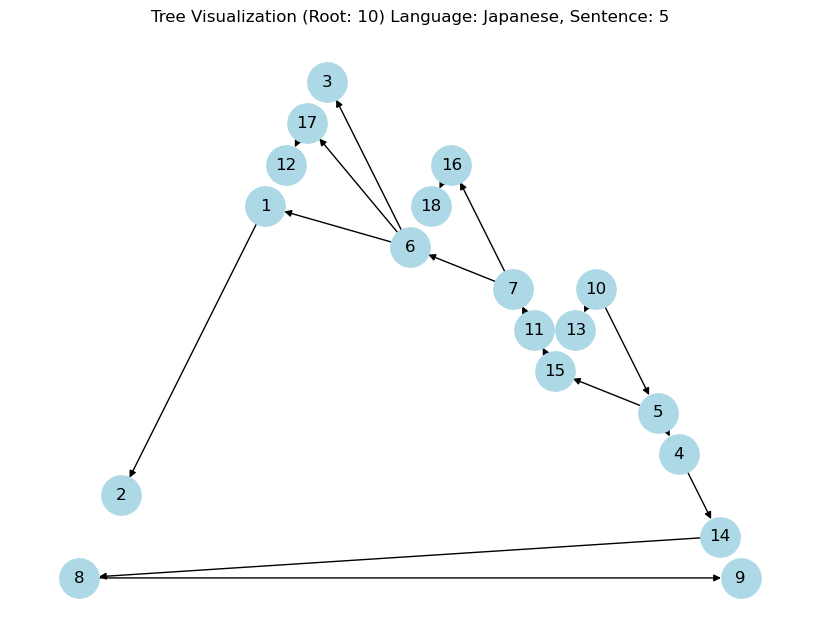

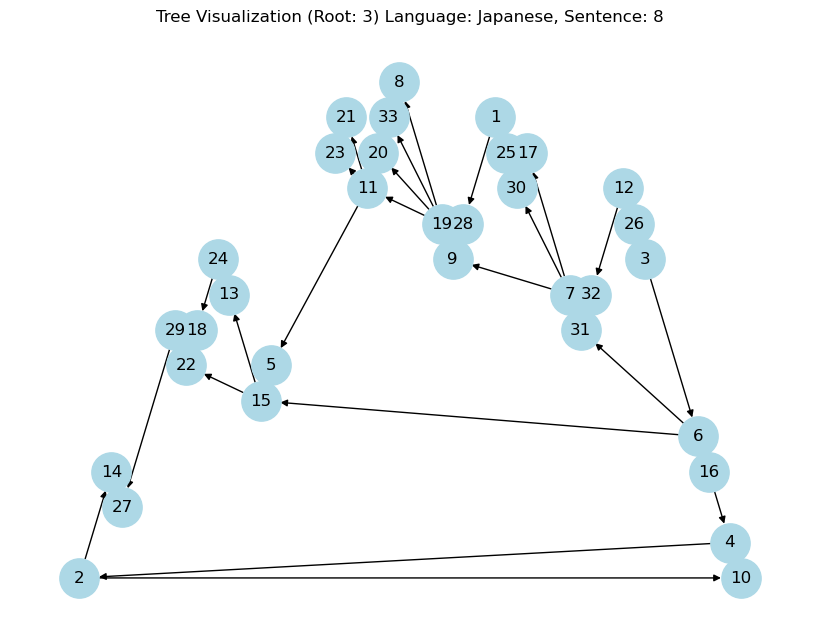

In [20]:
def visualize_tree(edges, root, title=""):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    pos = nx.planar_layout(G) if nx.is_planar(G) else nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color='lightblue')
    plt.title(f"Tree Visualization (Root: {root}) {title}")
    plt.show()

# Visualize first few trees
for i, row in df.head(3).iterrows():
    visualize_tree(ast.literal_eval(row['edgelist']), row['root'], f"Language: {row['language']}, Sentence: {row['sentence']}")

## Data Preprocessing

In [136]:
import ast
import pandas as pd
import networkx as nx
import numpy as np
from scipy import stats
from collections import Counter

def preprocess(df):
    """
    Enhanced preprocessing with additional features for tree root prediction
    """
    
    df['edgelist'] = df['edgelist'].apply(ast.literal_eval)
    
    def enhanced_features(edgelist):
        """
        Extract comprehensive features for tree root prediction
        """
        T = nx.from_edgelist(edgelist)
        
        # Basic centrality measures (your existing ones)
        dc = nx.degree_centrality(T)
        cc = nx.harmonic_centrality(T)
        bc = nx.betweenness_centrality(T)
        pc = nx.pagerank(T)
        clc = nx.closeness_centrality(T)
        kz = nx.katz_centrality_numpy(T, alpha=0.005, beta=1.0)
        lc = nx.load_centrality(T)
        andc = nx.average_neighbor_degree(T)
        
        # NEW FEATURES FOR ROOT PREDICTION
        
        
        # 2. Distance-based features
        # Average distance to all other nodes
        shortest_paths = dict(nx.all_pairs_shortest_path_length(T))
        avg_distances = {}
        sum_distances = {}
        
        for node in T.nodes():
            distances = list(shortest_paths[node].values())
            avg_distances[node] = np.mean(distances)
            sum_distances[node] = sum(distances)
        
        # 3. Tree-specific features
        # Distance from center(s) of the tree
        center_nodes = nx.center(T)
        periphery_nodes = nx.periphery(T)
        
        distance_from_center = {}
        distance_from_periphery = {}
       
        for node in T.nodes():
            # Distance to closest periphery
            distance_from_periphery[node] = min(nx.shortest_path_length(T, node, periph) 
                                              for periph in periphery_nodes)
      
        # 4. Subtree size features
        # For each node, compute size of subtree when that node is removed
        subtree_sizes = {}
        for node in T.nodes():
            T_copy = T.copy()
            T_copy.remove_node(node)
            components = list(nx.connected_components(T_copy))
            # Size of largest component when node is removed
            subtree_sizes[node] = max(len(comp) for comp in components) if components else 0
        
        # 5. Neighbor-based features
        neighbor_degrees = {}
        neighbor_centralities = {}
        second_order_neighbors = {}
        
        for node in T.nodes():
            neighbors = list(T.neighbors(node))
            if neighbors:
                neighbor_degrees[node] = np.mean([T.degree(n) for n in neighbors])
                neighbor_centralities[node] = np.mean([dc[n] for n in neighbors])
                # Second-order neighbors (neighbors of neighbors)
                second_neighbors = set()
                for neighbor in neighbors:
                    second_neighbors.update(T.neighbors(neighbor))
                second_neighbors.discard(node)  # Remove self
                second_order_neighbors[node] = len(second_neighbors)
            else:
                neighbor_degrees[node] = 0
                neighbor_centralities[node] = 0
                second_order_neighbors[node] = 0
        
        
        # 7. Relative position features
        # Node's degree relative to max degree
        max_degree = max(dict(T.degree()).values())
        relative_degree = {node: T.degree(node) / max_degree for node in T.nodes()}
        
        # Node's centrality relative to max centrality
        max_dc = max(dc.values())
        relative_centrality = {node: dc[node] / max_dc for node in T.nodes()}
        
        # 8. Tree depth features (if we can infer a root)
        # Use the most central node as a proxy root for depth calculation
        proxy_root = max(dc.keys(), key=lambda x: dc[x])
        depths_from_proxy = nx.single_source_shortest_path_length(T, proxy_root)
        
        # 9. Bridge and articulation point features
        bridges = list(nx.bridges(T))
        articulation_points = set(nx.articulation_points(T))
        
        is_articulation = {node: 1 if node in articulation_points else 0 for node in T.nodes()}
        bridge_count = {node: sum(1 for bridge in bridges if node in bridge) for node in T.nodes()}
        
        # 10. Statistical features within neighborhoods
        local_degree_variance = {}
        
        for node in T.nodes():
            neighbors = list(T.neighbors(node))
            if len(neighbors) > 1:
                neighbor_degrees_list = [T.degree(n) for n in neighbors]
                local_degree_variance[node] = np.var(neighbor_degrees_list)
            else:
                local_degree_variance[node] = 0
        
        # Combine all features
        features = {}
        for node in T.nodes():
            features[node] = (
                # Original centrality features
                dc[node], cc[node], bc[node], pc[node], clc[node], 
                kz[node], lc[node], andc[node],
                
                # New features
                avg_distances[node],               # 10: Average distance to all nodes
                sum_distances[node],               # 12: Sum of distances
                distance_from_periphery[node],     # 14: Distance from periphery
                subtree_sizes[node],               # 17: Size of largest subtree when removed
                neighbor_degrees[node],            # 18: Average neighbor degree
                neighbor_centralities[node],       # 19: Average neighbor centrality
                second_order_neighbors[node],      # 20: Number of second-order neighbors
                relative_degree[node],             # 22: Relative degree
                relative_centrality[node],         # 23: Relative centrality
                depths_from_proxy[node],           # 24: Depth from proxy root
                is_articulation[node],             # 25: Is articulation point
                bridge_count[node],                # 26: Number of bridges connected to
                local_degree_variance[node],       # 28: Local degree variance
                
            )
        
        return features
    
    df['centralities'] = df['edgelist'].apply(enhanced_features)
    
    def binary_classification(df):
        """
        Convert to binary classification format with enhanced features
        """
        records = []
        has_root = 'root' in df.columns
        
        for _, row in df.iterrows():
            for vertex, feature_tuple in row['centralities'].items():
                record = {
                    'language': row['language'],
                    'sentence': row['sentence'],
                    'n': row['n'],
                    'vertex': vertex,
                }
                
                # Add all features with descriptive names
                feature_names = [
                    'degree', 'harmonic', 'betweenness', 'pagerank', 'closeness',
                    'katz', 'load', 'avg_neighbor_degree',
                     'avg_distance', 'sum_distance',
                    'distance_from_periphery', 
                    'subtree_size',
                    'neighbor_degrees', 'neighbor_centralities', 'second_order_neighbors',
                     'relative_degree', 'relative_centrality',
                    'depth_from_proxy', 'is_articulation', 'bridge_count',
                    'local_degree_variance'
        
                ]
                
                for i, feature_name in enumerate(feature_names):
                    record[feature_name] = feature_tuple[i]
                
                if has_root:
                    record['root'] = row['root']
                records.append(record)
        
        binary_df = pd.DataFrame(records)
        binary_df = binary_df.sort_values(['language', 'sentence', 'vertex']).reset_index(drop=True)
        
        if has_root:
            binary_df['is_root'] = (binary_df['vertex'] == binary_df['root']).astype(int)
        
        return binary_df
    
    return binary_classification(df)

In [140]:
df = preprocess(df)

# check with project guideline
df[(df['language'] == 'Arabic') & (df['sentence'] == 62)]

#n number of nodes, 

,language,sentence,n,vertex,degree,harmonic,betweenness,pagerank,closeness,katz,...,neighbor_centralities,second_order_neighbors,relative_degree,relative_centrality,depth_from_proxy,is_articulation,bridge_count,local_degree_variance,root,is_root
588,Arabic,62,10,1,0.111111,3.950000,0.000000,0.058583,0.360000,0.314969,...,0.444444,3,0.25,0.25,1,0,1,0.0000,5,0
589,Arabic,62,10,2,0.222222,5.000000,0.500000,0.104807,0.473684,0.316552,...,0.333333,4,0.50,0.50,1,1,2,1.0000,5,0
590,Arabic,62,10,3,0.111111,3.950000,0.000000,0.058583,0.360000,0.314969,...,0.444444,3,0.25,0.25,1,0,1,0.0000,5,0
591,Arabic,62,10,4,0.111111,3.616667,0.000000,0.060961,0.310345,0.314961,...,0.333333,2,0.25,0.25,2,0,1,0.0000,5,0
592,Arabic,62,10,5,0.333333,5.283333,0.416667,0.162218,0.428571,0.318118,...,0.222222,3,0.75,0.75,1,1,3,2.0000,5,1
593,Arabic,62,10,6,0.111111,3.616667,0.000000,0.060961,0.310345,0.314961,...,0.333333,2,0.25,0.25,2,0,1,0.0000,5,0
594,Arabic,62,10,7,0.222222,4.500000,0.388889,0.108763,0.391304,0.316536,...,0.222222,2,0.50,0.50,2,1,2,0.0000,5,0
595,Arabic,62,10,8,0.222222,3.983333,0.222222,0.115810,0.310345,0.316528,...,0.166667,1,0.50,0.50,3,1,2,0.2500,5,0
596,Arabic,62,10,9,0.111111,3.016667,0.000000,0.064220,0.243243,0.314953,...,0.222222,1,0.25,0.25,4,0,1,0.0000,5,0
597,Arabic,62,10,10,0.444444,6.083333,0.750000,0.205094,0.529412,0.319693,...,0.194444,3,1.00,1.00,0,1,4,0.6875,5,0


In [141]:
#check columns where all values are 0
df.columns[(df == 0).all()]


Index([], dtype='object')

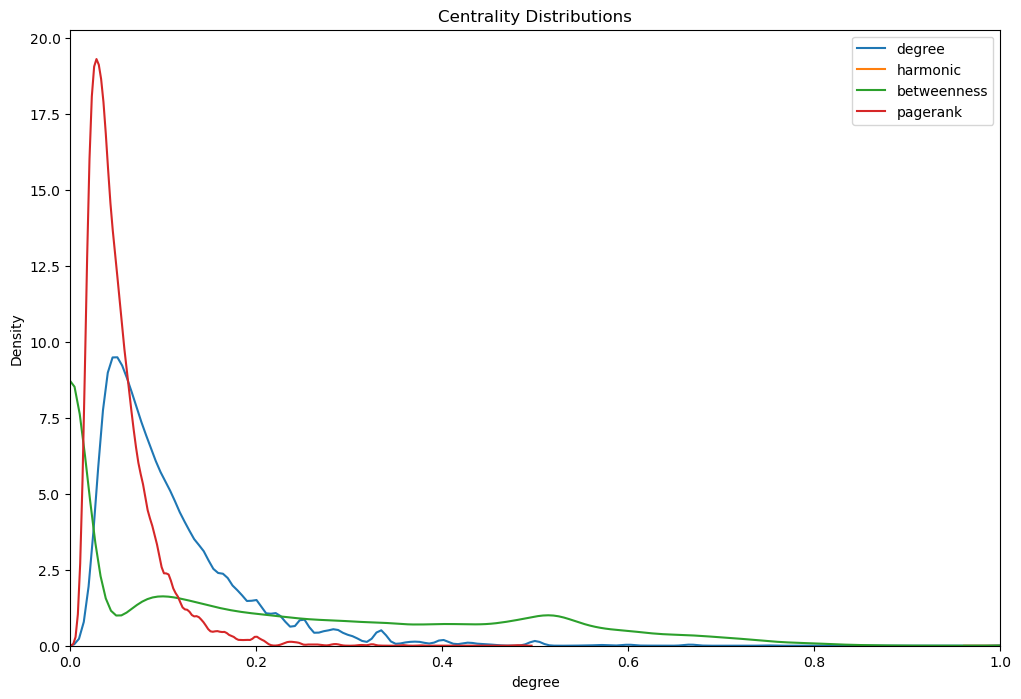

In [9]:
# 4. Analyze Centrality Distributions
plt.figure(figsize=(12,8))
for feature in ['degree', 'harmonic', 'betweenness', 'pagerank']:
    sns.kdeplot(df[feature], label=feature)
plt.title('Centrality Distributions')
plt.legend()
plt.xlim(0, 1)  # Limit x-axis from 0 to 5
plt.show()


In [144]:
# drop root column
df = df.drop('root', axis=1)

## Data Exploration of the Expanded Data

In [146]:
# save expanded data
df.to_csv('binary_dataset.csv', index=False)

In [147]:
train_df = pd.read_csv('binary_dataset.csv')

In [149]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197479 entries, 0 to 197478
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   language                 197479 non-null  object 
 1   sentence                 197479 non-null  int64  
 2   n                        197479 non-null  int64  
 3   vertex                   197479 non-null  int64  
 4   degree                   197479 non-null  float64
 5   harmonic                 197479 non-null  float64
 6   betweenness              197479 non-null  float64
 7   pagerank                 197479 non-null  float64
 8   closeness                197479 non-null  float64
 9   katz                     197479 non-null  float64
 10  load                     197479 non-null  float64
 11  avg_neighbor_degree      197479 non-null  float64
 12  avg_distance             197479 non-null  float64
 13  sum_distance             197479 non-null  int64  
 14  dist

- change language to categorical variable


In [151]:
train_df['language'] = train_df['language'].astype('category')

In [155]:
# get number of rows and columns
train_df.shape

(197479, 26)

In [157]:
# confirm there are no missing values
train_df.isnull().sum()

language                   0
sentence                   0
n                          0
vertex                     0
degree                     0
harmonic                   0
betweenness                0
pagerank                   0
closeness                  0
katz                       0
load                       0
avg_neighbor_degree        0
avg_distance               0
sum_distance               0
distance_from_periphery    0
subtree_size               0
neighbor_degrees           0
neighbor_centralities      0
second_order_neighbors     0
relative_degree            0
relative_centrality        0
depth_from_proxy           0
is_articulation            0
bridge_count               0
local_degree_variance      0
is_root                    0
dtype: int64

In [159]:
# Check for duplicates
train_df.duplicated().sum()

0

In [160]:
train_df.describe()

,sentence,n,vertex,degree,harmonic,betweenness,pagerank,closeness,katz,load,...,neighbor_degrees,neighbor_centralities,second_order_neighbors,relative_degree,relative_centrality,depth_from_proxy,is_articulation,bridge_count,local_degree_variance,is_root
count,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,...,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000
mean,499.636584,22.374151,11.687076,0.106340,6.590969,0.187322,0.053170,0.245772,0.225162,0.187322,...,2.597542,0.145223,2.661893,0.455551,0.455551,3.182865,0.583262,1.893660,0.477550,0.053170
std,291.353683,8.959233,8.269808,0.078688,2.057981,0.217725,0.036490,0.088976,0.049724,0.217725,...,0.933026,0.088021,1.492335,0.246057,0.246057,2.360529,0.493020,0.984688,0.904824,0.224373
min,2.000000,3.000000,1.000000,0.014493,1.500000,0.000000,0.007699,0.062864,0.118939,0.000000,...,1.000000,0.021739,0.000000,0.111111,0.111111,0.000000,0.000000,1.000000,0.000000,0.000000
25%,238.000000,16.000000,5.000000,0.052632,5.120635,0.000000,0.028860,0.183673,0.191554,0.000000,...,2.000000,0.086957,2.000000,0.250000,0.250000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,491.000000,21.000000,10.000000,0.083333,6.333333,0.105105,0.043185,0.230216,0.217238,0.105105,...,2.333333,0.125000,2.000000,0.400000,0.400000,3.000000,1.000000,2.000000,0.000000,0.000000
75%,736.000000,27.000000,16.000000,0.133333,7.782527,0.341667,0.066175,0.290000,0.250142,0.341667,...,3.000000,0.177778,4.000000,0.600000,0.600000,4.000000,1.000000,2.000000,0.666667,0.000000
max,995.000000,70.000000,70.000000,1.000000,20.078175,1.000000,0.486486,1.000000,0.579260,1.000000,...,9.000000,1.000000,15.000000,1.000000,1.000000,21.000000,1.000000,9.000000,16.000000,1.000000


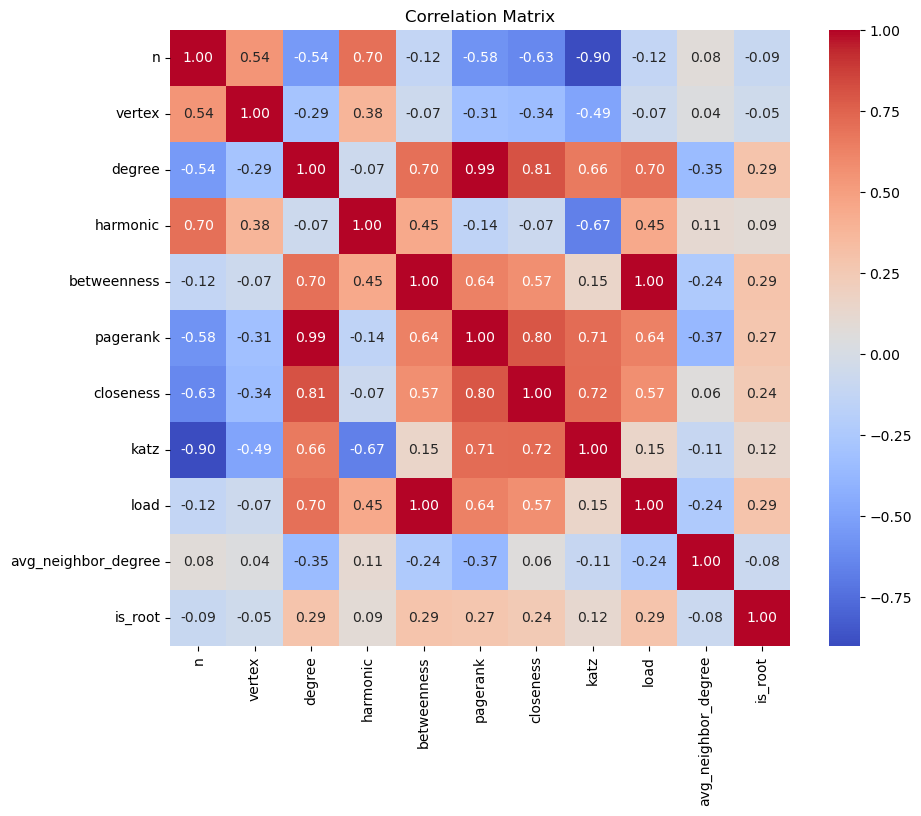

In [27]:
# check the carrelation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['sentence', 'language'], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Resampling: Splitting Data into Train and Validation Set

To estimate the generalization error, we split the data into train and validation set. We will then use a 5-fold cross validation over the train set so we train over a good sample of the data

In [164]:
# separate features and target value
X = train_df.drop('is_root', axis=1)
y = train_df['is_root']


In [166]:
# to avoid data leakage use group split
from sklearn.model_selection import GroupShuffleSplit

# Grouping by sentence ID
groups = train_df['sentence'] 

# Perform group split (80% train, 20% val)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Verify no sentence appears in both splits
train_sentences = set(groups.iloc[train_idx])
val_sentences = set(groups.iloc[val_idx])
assert train_sentences.isdisjoint(val_sentences), "Data leakage detected!"

## Per Sentence Normalization

It will be better to normalize the data since it has different different ranges. we have to do a sentence level normalization because different sentences have different number of nodes

Note: Group by language then sentence coz per sentence will scale all the sentences from all the languages as one. however for example, Arabic and Turkish trees for the same sentence may have different structures, so we Normalize per-language AND per-sentence by grouping by both language and sentence. treating them as a single group would mix languages during normalization.

In [173]:
from sklearn.preprocessing import MinMaxScaler

features = X_train.drop(['language', 'sentence', 'n', 'vertex'], axis=1).columns

def scaling(X):
    """
    Normalize features using MinMaxScaler
    """
    normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())
    X_ft= X.drop(features, axis=1) 
    normalized_X = pd.concat([X_ft, normalized_ft], axis=1)
    
    return normalized_X

X_train_normalized = scaling(X_train)
X_val_normalized = scaling(X_val)

C:\Users\nifeo\AppData\Local\Temp\ipykernel_27228\1461406940.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())
C:\Users\nifeo\AppData\Local\Temp\ipykernel_27228\1461406940.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())


we fit and transform the test set independently because the sentences are different in the two sets, so we can't use the scalers used for train to transform the test set, as we performed a within sentence normalization

We also only performed normalization on the centrality metrics and on the number of nodes n

In [175]:
# drop columns not useful
X_train_normalized = X_train_normalized.drop(['language', 'sentence', 'vertex'], axis=1)
X_val_normalized = X_val_normalized.drop(['language', 'sentence', 'vertex'], axis=1)

## Modeling

### Linear Classifiers

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score

lg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1],             # Regularization strength
    'penalty': ['l2'],                  # l1 requires solver='liblinear' or 'saga'
    'solver': ['lbfgs', 'liblinear'],                # 'lbfgs' supports l2 and multiclass
}

grid_search = GridSearchCV(
    estimator=lg_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',   
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])


# Train
logreg = grid_search.best_estimator_

# Predict
y_pred = logreg.predict(X_val_normalized)
y_probs = logreg.predict_proba(X_val_normalized)[:, 1]  # Probabilities for root class

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [182]:
# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))


Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     37903
           1       0.15      0.79      0.25      2100

    accuracy                           0.74     40003
   macro avg       0.57      0.77      0.55     40003
weighted avg       0.94      0.74      0.81     40003

Test F1 Score: 0.24574334782929166


## Non Linear Classifiers

In [201]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score

# Define KNN model
knn_model = KNeighborsClassifier()

# Hyperparameter grid for KNN
param_grid = {
    'n_neighbors': [1, 3, 5],
    'metric': ['euclidean', 'minkowski', 'manhattan']
}

# Grid search with GroupKFold
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])

# Best estimator
knn = grid_search.best_estimator_

# Predict
y_pred = knn.predict(X_val_normalized)

# Probabilities (only works if n_neighbors > 1)
y_probs = knn.predict_proba(X_val_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     37903
           1       0.22      0.22      0.22      2100

    accuracy                           0.92     40003
   macro avg       0.59      0.59      0.59     40003
weighted avg       0.92      0.92      0.92     40003

Test F1 Score: 0.22216867469879517


## Ensemble Methods

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline

# Initialize Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1  # Parallel processing
)

# Parameter grid for tuning
param_grid = {
    'n_estimators': [200, 250],       # Number of trees
    'max_depth': [20, 30, 50],      # Tree depth
    'min_samples_split': [5, 10],      # Minimum samples to split
    'min_samples_leaf': [6, 10],
}

# Group-aware GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),  # 10-fold grouped CV
    scoring='f1',                # Focus on F1 for root class
    n_jobs=-1,                   # Parallelize
    verbose=1
)

# Fit (ensure X_train doesn't contain 'sentence' column)
grid_search.fit(
    X_train_normalized,  # Exclude group identifier
    y_train,
    groups=X_train['sentence']  # Grouping key
)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_val_normalized)
y_probs = best_rf.predict_proba(X_val_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))

# Feature Importance
importances = best_rf.feature_importances_
print("Feature Importances:", dict(zip(X_train_normalized, importances)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     37903
           1       0.27      0.52      0.36      2100

    accuracy                           0.90     40003
   macro avg       0.62      0.72      0.65     40003
weighted avg       0.94      0.90      0.92     40003

Test F1 Score: 0.3560260586319218
Feature Importances: {'n': 0.05277589526973423, 'degree': 0.03096113752271759, 'harmonic': 0.08960900322919667, 'betweenness': 0.10427620727455174, 'pagerank': 0.06635948619320022, 'closeness': 0.04340853733381515, 'katz': 0.0776599511112263, 'load': 0.11008331056025425, 'avg_neighbor_degree': 0.017964995492760948, 'avg_distance': 0.037734925619783026, 'sum_distance': 0.03680916410145642, 'distance_from_periphery': 0.024767248618540197, 'subtree_size': 0.08115194549639

## Fit the Chosen Model on Entire Train Test

In [192]:
X_normalized = scaling(X).drop(['language', 'sentence', 'vertex'], axis=1)
X_normalized.head(1)

C:\Users\nifeo\AppData\Local\Temp\ipykernel_27228\1461406940.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())


,n,degree,harmonic,betweenness,pagerank,closeness,katz,load,avg_neighbor_degree,avg_distance,...,subtree_size,neighbor_degrees,neighbor_centralities,second_order_neighbors,relative_degree,relative_centrality,depth_from_proxy,is_articulation,bridge_count,local_degree_variance
0,21,0.0,0.371857,0.0,0.0,0.629551,0.002494,0.0,1.0,0.22093,...,1.0,1.0,1.0,0.333333,0.0,0.0,0.363636,0.0,0.0,0.0


In [193]:
# Fit whole data
best_rf.fit(X_normalized, y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=50,
                       min_samples_leaf=10, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

## Make Predictions on Test Set

In [197]:
# read test data
test_df = pd.read_csv('test.csv')
X_test = preprocess(test_df)
test_normalized = scaling(X_test).drop(['language', 'sentence', 'vertex'], axis=1)

# Predictions
test_pred = best_rf.predict(test_normalized)
test_probs = best_rf.predict_proba(test_normalized)[:, 1]

X_test['probability'] = test_probs

df_max = X_test.loc[X_test.groupby(['language', 'sentence'])['probability'].idxmax()]

df_max = df_max[['language','sentence', 'vertex']].rename(columns={'vertex': 'root'}).reset_index(drop=True)


submission_df = test_df.merge(df_max, on=['language', 'sentence'], how='left')
submission_df = submission_df[['id', 'root']]

submission_df

,id,root
0,1,37
1,2,46
2,3,2
3,4,18
4,5,3
...,...,...
10390,10391,13
10391,10392,8
10392,10393,21
10393,10394,20


In [198]:

submission_df.to_csv('submission_randomforest_features.csv', index=False)
print("Submission file created: submission_randomforest_features.csv")


Submission file created: submission_randomforest_features.csv


accuracy shouldnt be used as a metric when there is class imbalance